# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

## Imports

In [38]:
import os
#Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import re

from utils import get_dataset

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle

import numpy as np
import pandas as pd

import tensorflow.compat.v1 as tf
from object_detection.protos import input_reader_pb2
from object_detection.builders.dataset_builder import build as build_dataset

## Read dataset

In [2]:
#Read both train and validation data
dataset = get_dataset("data/*/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/*/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/*/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 96
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Helper functions

In [3]:
def brightness(img):
    """
    Calculates the brightness of an image.
    Args:
        img: Numpy array with shape [width, height, 3], datatype: uint8, rgb colors
    
    Returns:
        brightness
    
    Raises:
        No exceptions raised
    """
    #https://stackoverflow.com/questions/3490727/what-are-some-methods-to-analyze-image-brightness-using-python
    r,g,b = img.mean(axis=(0,1))
    return int(np.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2)))

In [4]:
def display_instances(elem, idx):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    Args:
        batch: Dictionary holding one element from a tensorflow dataset.
    
    Returns:
        No returns
    
    Raises:
        No exceptions raised
    """

    #Mapping of object classes to class id retrieved from file "label_map.pbtxt"
    #Could not find this information in the dataset
    #1:'vehicle' -> red
    #2:'pedestrian' -> green
    #4:'cyclist' -> blue
    object_color_map = {1:'red', 2:'green', 4:'blue'}
    
    #Get image data
    img = elem['image'].numpy()

    #Get bounding boxes
    boxes = elem['groundtruth_boxes'].numpy()

    #Get groundtruth classes
    classes = elem['groundtruth_classes'].numpy()

    #Create new figure and plot image
    _, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)
    plt.axis("off")

    #Print brightness of image as title
    plt.title(f"Brightness = {brightness(img)}")
    #plt.title(elem['filename'].numpy().decode())


    #get width and height of image
    (width, height, _) = img.shape

    #scale factor for scaling relative bounding box coordinates to absolute image coordinates
    box_scale_fac = [height, width, height, width]

    #Draw bounding boxes
    for (bb, class_id) in zip(boxes, classes):
        #Scale bounding box coordinates to absolute image coordinates
        y1, x1, y2, x2 = bb * box_scale_fac
        #Create and draw bounding box
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor=object_color_map[class_id])
        ax.add_patch(rec)

    plt.savefig(f"RawImages/{idx}.png")


In [5]:
%%html
<style>
table {float:left}
</style>

## Display 10 images from dataset

Object classes are color coded
|Object class|Color|
|------------|-------|
|Vehicles|red|
|Pedestrian|green|
|Cyclists|blue|

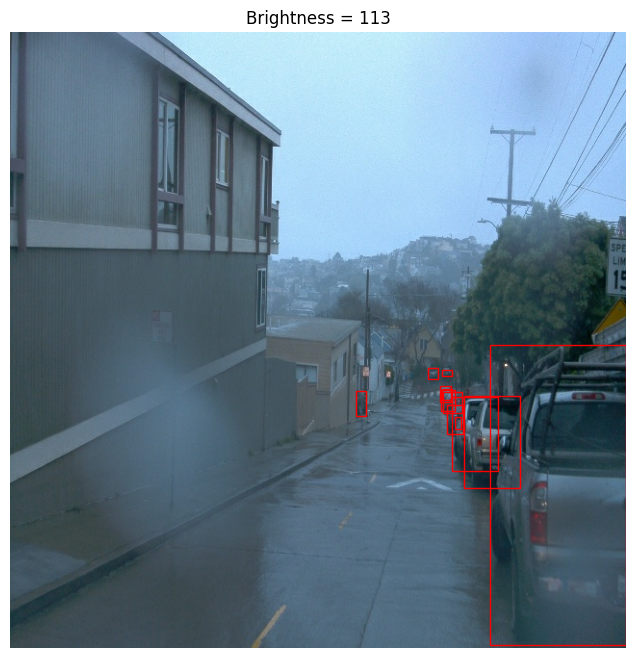

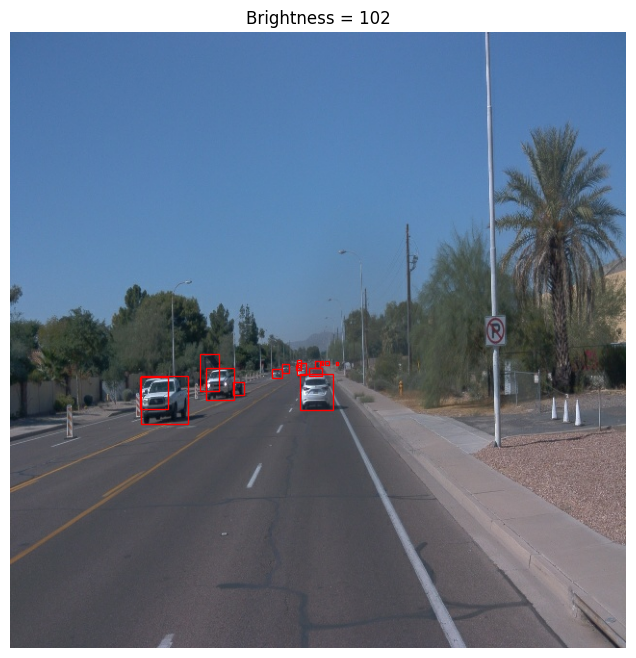

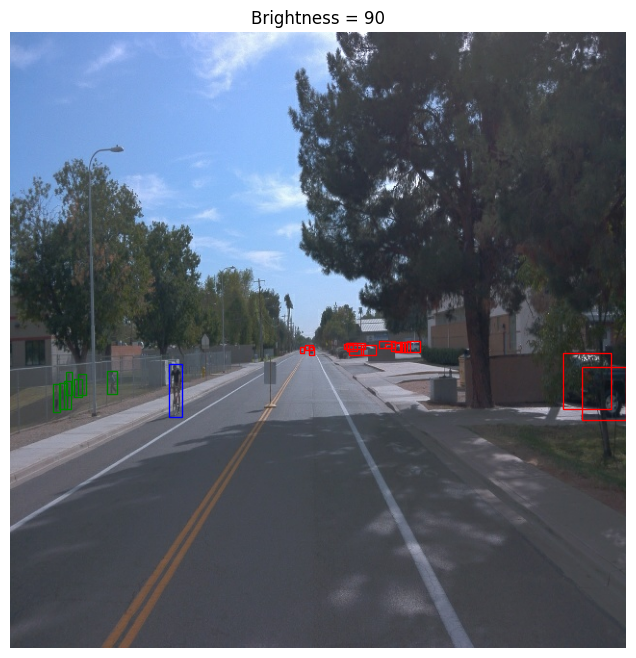

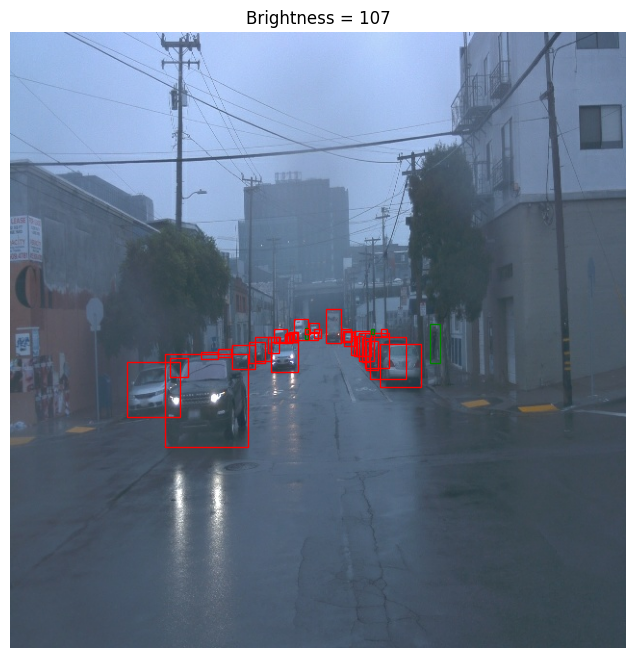

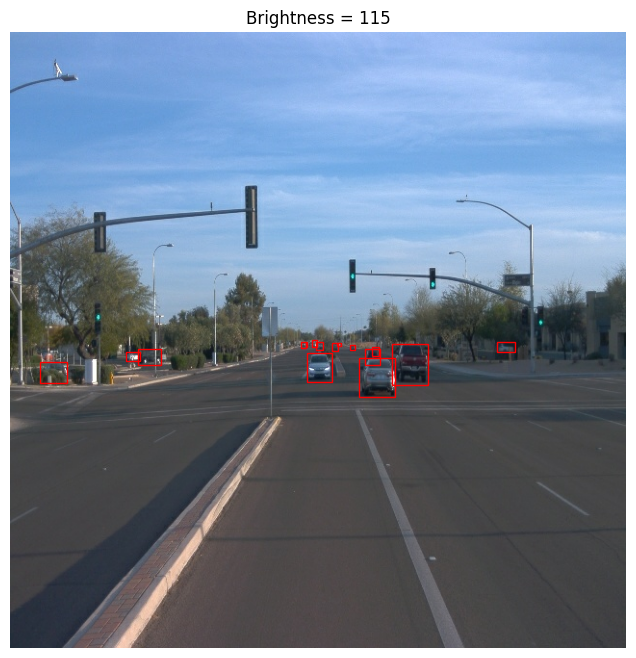

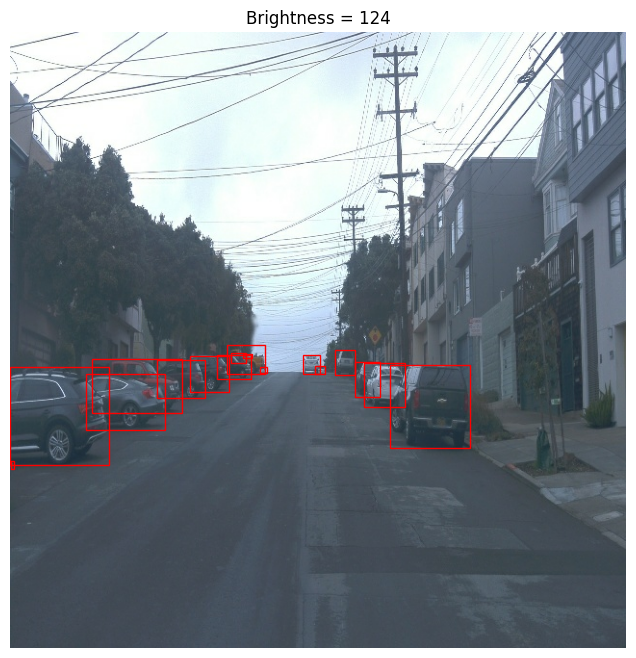

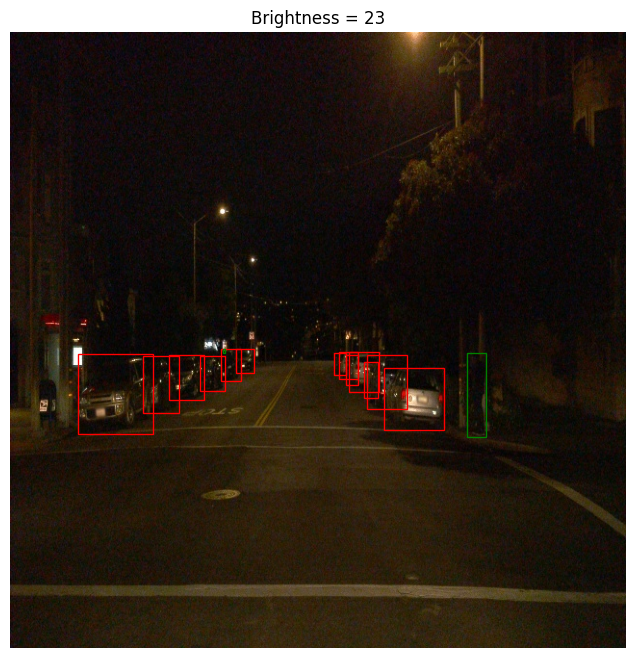

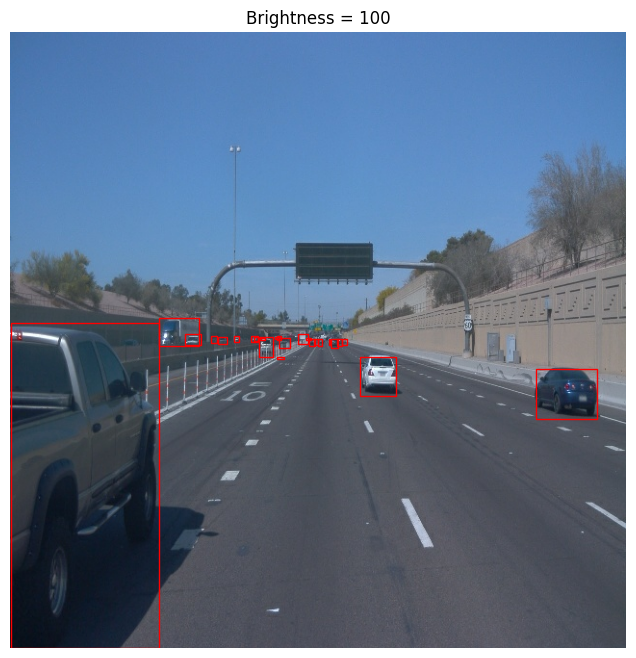

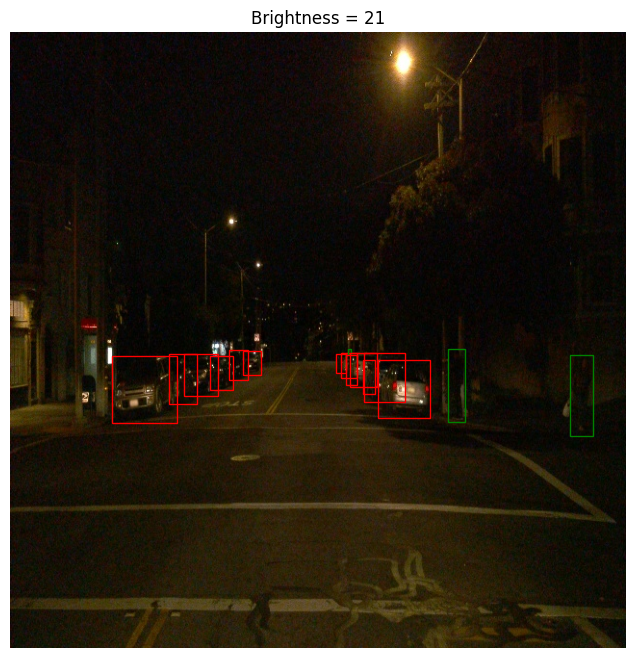

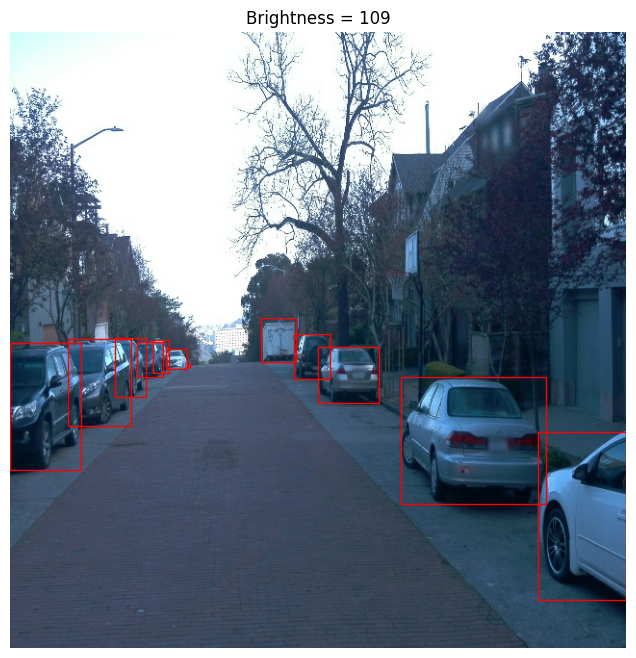

In [6]:
#Get 10 elements from the dataset and display the images with the respective bounding boxes
for idx, elem in enumerate(dataset.take(10)):
    display_instances(elem, idx)

In [7]:
#Get 9 elements from the dataset and display the images with the respective bounding boxes
#for elem in dataset.take(10):
#    display_instances(elem)

## Additional EDA

### Notes on this section
For quite some time, I struggeled with the problem, that the iteration over the dataset as return by the function get_dataset (utils.py) was infinite. After some digging, I think is must have to do with the configuration if the InputReader in function get_dataset, specifically that input_config.num_epochs = 0 by default.
For the additional EDA, I'd like to perform some statistics, so it was essential to see all images (frames) exactly one. To achive this, I made a copy of the function get_dataset with a slighly changed configuration of the InputReader.

In [8]:
def get_dataset_2(tfrecord_path, label_map='label_map.pbtxt'):
    """
    Opens a tf record file and create tf dataset
    args:
      - tfrecord_path [str]: path to a tf record file
      - label_map [str]: path the label_map file
    returns:
      - dataset [tf.Dataset]: tensorflow dataset
    """
    input_config = input_reader_pb2.InputReader()
    input_config.label_map_path = label_map
    input_config.tf_record_input_reader.input_path[:] = [tfrecord_path]
    
    #avoid infinte iteration
    input_config.num_epochs = 1

    #for stats there is no need for shuffling
    input_config.shuffle = False
    
    dataset = build_dataset(input_config)
    return dataset

### Plan for EDA
The training and validation data set shall be compared.<br> 
The following stats shall be calculated for every frame in the datasets:
- Number of objects
- Number of vehicles
- Number of pedestrians
- Total number of objects per class (thanks to the reviewer for pointing that out)
- Number of cyclist
- Brightness of image
  

Histograms shall be plotted for each of the stats, which show the two data sets side by side.


In [9]:
dataset_train = get_dataset_2("data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86


In [10]:
dataset_val = get_dataset_2("data/val/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/val/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/val/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 10


In [11]:
def CollectInfo(dataset):
    """
    Create stats from tensorflow dataset
    args:
      - dataset: tensorflow dataset
    returns:
      - Pandas dataframe with one entry per frame
    """    
    #Result data
    rows = []
    
    #object_classes = {1:'vehicle', 2:'pedestrian', 4:'cyclist'}

    for elem in dataset:
        #Result row
        row = {}

        #Get groundtruth object classes
        gt = elem['groundtruth_classes'].numpy()
        
        #Number of groundtruth objects
        row['NumberOfObjects'] = len(gt)

        #Number of vehicles
        row['NumberOfVehicles'] = (gt == 1).sum()

        #Number of pedestrians
        row['NumberOfPedestrians'] = (gt == 2).sum()

        #Number of cyclists
        row['NumberOfCyclists'] = (gt == 4).sum()

        #Get image brightness
        row['Brightness'] = brightness(elem['image'].numpy())

        rows.append(row)
        
    return pd.DataFrame.from_dict(rows, orient='columns')

In [12]:
#Get stats for validation dataset
df_val = CollectInfo(dataset_val)

In [13]:
#Get stats for validation dataset
df_train = CollectInfo(dataset_train)

In [14]:
#Check pandas df types
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   NumberOfObjects      198 non-null    int64
 1   NumberOfVehicles     198 non-null    int64
 2   NumberOfPedestrians  198 non-null    int64
 3   NumberOfCyclists     198 non-null    int64
 4   Brightness           198 non-null    int64
dtypes: int64(5)
memory usage: 7.9 KB


In [15]:
#Check pandas df types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719 entries, 0 to 1718
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   NumberOfObjects      1719 non-null   int64
 1   NumberOfVehicles     1719 non-null   int64
 2   NumberOfPedestrians  1719 non-null   int64
 3   NumberOfCyclists     1719 non-null   int64
 4   Brightness           1719 non-null   int64
dtypes: int64(5)
memory usage: 67.3 KB


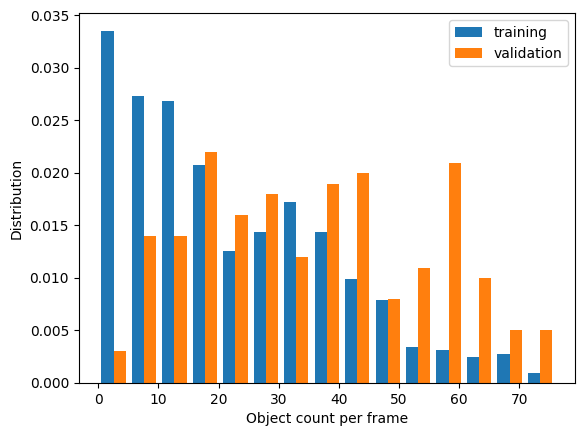

In [16]:
#Plot histogramm for number of objects per frame
plt.hist([df_train['NumberOfObjects'], df_val['NumberOfObjects']], 15, density=True, histtype='bar')
plt.legend(('training', 'validation'))
plt.xlabel('Object count per frame')
plt.ylabel('Distribution')
plt.savefig('EDA/HistNumObj.png')

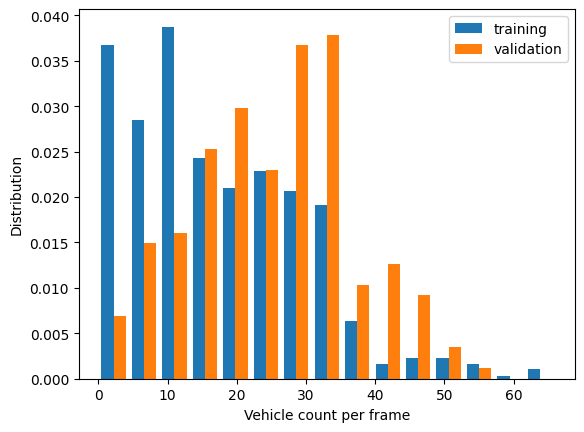

In [17]:
#Plot histogramm for number of vehicles per frame
plt.hist([df_train['NumberOfVehicles'], df_val['NumberOfVehicles']], 15, density=True, histtype='bar')
plt.legend(('training', 'validation'))
plt.xlabel('Vehicle count per frame')
plt.ylabel('Distribution')
plt.savefig('EDA/HistNumVeh.png')

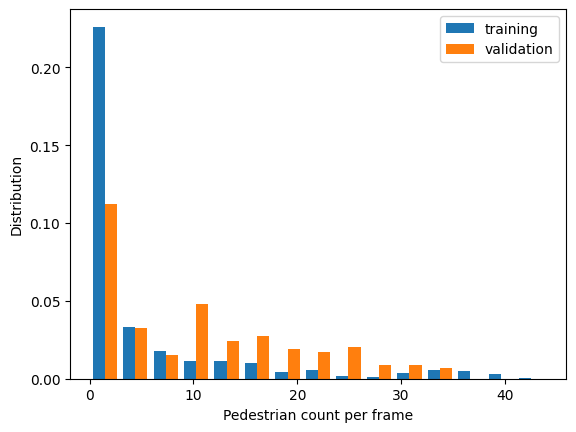

In [18]:
#Plot histogramm for number of pedestrians per frame
plt.hist([df_train['NumberOfPedestrians'], df_val['NumberOfPedestrians']], 15, density=True, histtype='bar')
plt.legend(('training', 'validation'))
plt.xlabel('Pedestrian count per frame')
plt.ylabel('Distribution')
plt.savefig('EDA/HistNumPed.png')

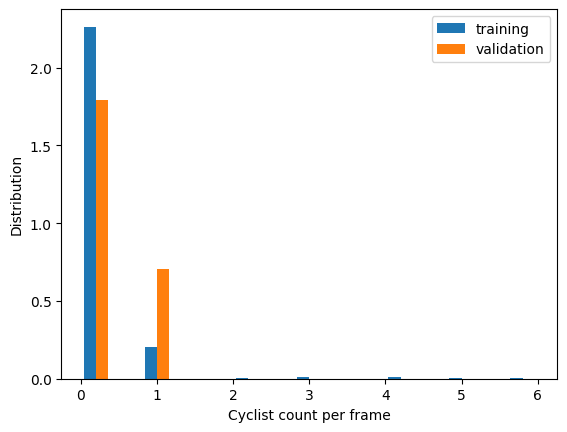

In [23]:
#Plot histogramm for number of cyclists per frame
plt.hist([df_train['NumberOfCyclists'], df_val['NumberOfCyclists']], 15, density=True, histtype='bar')
plt.legend(('training', 'validation'))
plt.xlabel('Cyclist count per frame')
plt.ylabel('Distribution')
plt.savefig('EDA/HistNumCyc.png')

Vehicles       29710
Pedestrians     8355
Cyclists         214
dtype: int64

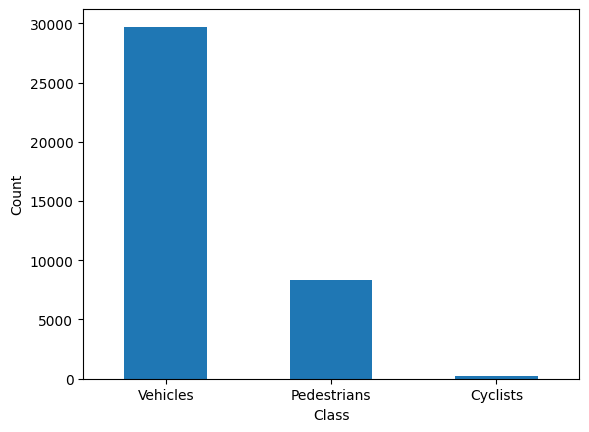

In [43]:
#Total number of objects per class in the training data
df_train[['NumberOfVehicles','NumberOfPedestrians','NumberOfCyclists']].rename(columns=lambda x: re.sub('NumberOf','',x)).sum(axis=0).plot(kind='bar', rot=0)
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('EDA/ObjectsPerClass.png')
df_train[['NumberOfVehicles','NumberOfPedestrians','NumberOfCyclists']].rename(columns=lambda x: re.sub('NumberOf','',x)).sum(axis=0)

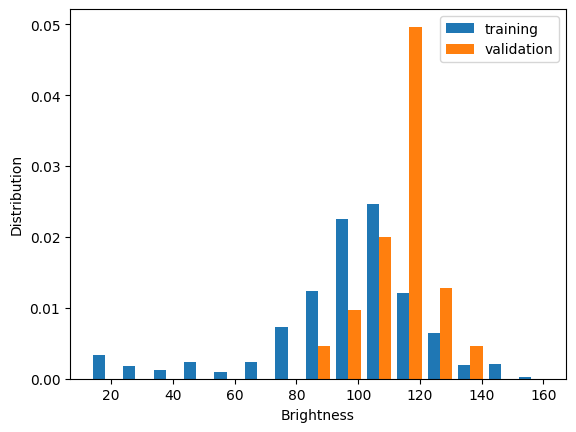

In [20]:
#Plot histogramm for image brightness
plt.hist([df_train['Brightness'], df_val['Brightness']], 15, density=True, histtype='bar')
plt.legend(('training', 'validation'))
plt.xlabel('Brightness')
plt.ylabel('Distribution')
plt.savefig('EDA/HistBrightness.png')

In [21]:
#Get basic stats
df_val.describe(include='all')

NumberOfObjects  NumberOfVehicles  NumberOfPedestrians  \
count       198.000000        198.000000           198.000000   
mean         35.742424         25.015152            10.444444   
std          18.663173         11.492870             9.742598   
min           5.000000          3.000000             0.000000   
25%          20.000000         17.000000             1.000000   
50%          35.500000         26.000000             9.000000   
75%          51.750000         32.000000            17.000000   
max          76.000000         53.000000            35.000000   

       NumberOfCyclists  Brightness  
count        198.000000  198.000000  
mean           0.282828  113.535354  
std            0.451515   10.565544  
min            0.000000   84.000000  
25%            0.000000  110.000000  
50%            0.000000  115.000000  
75%            1.000000  118.000000  
max            1.000000  138.000000

In [22]:
#Get basic stats
df_train.describe(include='all')

NumberOfObjects  NumberOfVehicles  NumberOfPedestrians  \
count      1719.000000       1719.000000          1719.000000   
mean         22.268179         17.283304             4.860384   
std          16.896269         12.393364             9.006998   
min           0.000000          0.000000             0.000000   
25%           8.000000          7.000000             0.000000   
50%          18.000000         15.000000             1.000000   
75%          34.000000         26.000000             5.000000   
max          76.000000         66.000000            44.000000   

       NumberOfCyclists   Brightness  
count       1719.000000  1719.000000  
mean           0.124491    95.826062  
std            0.469909    25.866868  
min            0.000000    13.000000  
25%            0.000000    87.000000  
50%            0.000000   100.000000  
75%            0.000000   110.000000  
max            6.000000   161.000000

### EDA summary
The training data set contains 1719 and the validation data set 198 individual pictures. According to the histogram plot as well as to the median in the descriptive statistics, the validation data set generally contains more objects per frame compared with the training data set.
In both data set, there are almost no cyclists. Most of the objects are vehicles.
The average image brightness is quite comparable in both data sets, though the validation set does not contain really dim images.
In the training data set, the proportions of the object number per class is quite different. The majority of ground truth objects in the training data are vehicles (29710), there are less pedestrians (8355) and only a few cyclists (214). According to this (machine learning course)[https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data?hl=en], the dataset is extremely imbalanced and special attention is needed when training the model. Thanks to the reviewer for pointing that important topic out.